**Importing Packages**

Python packages enable different functions, providing easy ways of manipulating data and building models. As a first step, we 'import' packages to set up our environment in a way that allows us to take advantage of different capabilities.

Import the necessary libraries.

In [ ]:
!python --version

Python 3.11.5


In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

import tensorflow as tf
from tensorflow.keras import layers


from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, Embedding
from tensorflow.keras.models import Sequential


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
# Setting Random Seed to Control Random Start Value for Easier Model Performance Comparison
seed_value = 100

################### also add this one to make sure the consistent.
tf.random.set_seed(seed_value)
###################

tf.keras.utils.set_random_seed(seed_value)
tf.config.experimental.enable_op_determinism()

Now we will set our path for Google Drive in order to read dataset via Google Drive.

In [3]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    print("Mounting Failed.")

Mounted at /content/drive


In [5]:
words = []
embeddings = []

with open('/content/drive/MyDrive/BDML/glove.6B.100d.txt', 'r') as f:
    for line in tqdm(f, total=400_000):
        word, *vector = line.split()
        words.append(word)
        embeddings.append(vector)

  0%|          | 0/400000 [00:00<?, ?it/s]

In [6]:
words[0]

'the'

In [7]:
embeddings[0]

['-0.038194',
 '-0.24487',
 '0.72812',
 '-0.39961',
 '0.083172',
 '0.043953',
 '-0.39141',
 '0.3344',
 '-0.57545',
 '0.087459',
 '0.28787',
 '-0.06731',
 '0.30906',
 '-0.26384',
 '-0.13231',
 '-0.20757',
 '0.33395',
 '-0.33848',
 '-0.31743',
 '-0.48336',
 '0.1464',
 '-0.37304',
 '0.34577',
 '0.052041',
 '0.44946',
 '-0.46971',
 '0.02628',
 '-0.54155',
 '-0.15518',
 '-0.14107',
 '-0.039722',
 '0.28277',
 '0.14393',
 '0.23464',
 '-0.31021',
 '0.086173',
 '0.20397',
 '0.52624',
 '0.17164',
 '-0.082378',
 '-0.71787',
 '-0.41531',
 '0.20335',
 '-0.12763',
 '0.41367',
 '0.55187',
 '0.57908',
 '-0.33477',
 '-0.36559',
 '-0.54857',
 '-0.062892',
 '0.26584',
 '0.30205',
 '0.99775',
 '-0.80481',
 '-3.0243',
 '0.01254',
 '-0.36942',
 '2.2167',
 '0.72201',
 '-0.24978',
 '0.92136',
 '0.034514',
 '0.46745',
 '1.1079',
 '-0.19358',
 '-0.074575',
 '0.23353',
 '-0.052062',
 '-0.22044',
 '0.057162',
 '-0.15806',
 '-0.30798',
 '-0.41625',
 '0.37972',
 '0.15006',
 '-0.53212',
 '-0.2055',
 '-1.2526',
 '0.0

In [8]:
embeddings = np.float32(np.array(embeddings))
embeddings.shape

(400000, 100)

In [9]:
embeddings = np.concatenate([np.zeros((2, 100)),
                            embeddings], axis=0)

In [10]:
word2idx = {w: i+2 for i, w in enumerate(words)}
idx2word = {i+2: w for i, w in enumerate(words)}

word2idx['PAD'] = 0
idx2word[0] = 'PAD'

word2idx['OOV'] = 1
idx2word[1] = 'OOV'

In [14]:
df = pd.read_csv('/content/drive/MyDrive/BDML/news_data.csv')
print(df.iloc[0,0])
print(df.iloc[0,1])

The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and powerful commercial model .
positive


In [15]:
keys = np.unique(df.Sentiment)
values = list(range(len(keys)))
label_mapper = dict(zip(keys, values))
label_mapper

{'negative': 0, 'neutral': 1, 'positive': 2}

In [16]:
df.Sentiment = df.Sentiment.map(label_mapper)
df.Sentence = df.Sentence.apply(lambda x: x.lower())
df.head()

,Sentence,Sentiment
0,the geosolutions technology will leverage bene...,2
1,"$esi on lows, down $1.50 to $2.50 bk a real po...",0
2,"for the last quarter of 2010 , componenta 's n...",2
3,according to the finnish-russian chamber of co...,1
4,the swedish buyout firm has sold its remaining...,1


In [ ]:
df.Sentence = df.Sentence.apply(lambda x: word_tokenize(x))
df.head()

In [19]:
len(df.iloc[0,0])

32

In [20]:
def indexing_fn(tokens):
    idxs = []
    for token in tokens:
        idxs.append(word2idx.get(token, word2idx['OOV']))
    return idxs

In [21]:
df.Sentence = df.Sentence.apply(indexing_fn)
df.head()

,Sentence,Sentiment
0,"[2, 1, 734, 45, 10746, 1, 11, 14652, 4802, 23,...",2
1,"[82, 80988, 15, 9831, 3, 137, 82, 17310, 6, 82...",0
2,"[12, 2, 78, 550, 5, 657, 3, 1, 11, 1052, 528, ...",2
3,"[202, 6, 2, 1, 3198, 5, 2304, 3, 66, 2, 226, 9...",1
4,"[2, 2794, 11551, 1003, 33, 921, 49, 1528, 3179...",1


In [22]:
len(df.iloc[0,0])

32

In [23]:
padded_idx = tf.keras.preprocessing.sequence.pad_sequences(df.Sentence,
                                                          maxlen=128,
                                                          padding='post',
                                                          truncating='post')

In [24]:
X_train, X_test = train_test_split(padded_idx, test_size=0.2, shuffle=True, random_state=0, stratify=df.Sentiment)
y_train, y_test = train_test_split(df.Sentiment, test_size=0.2, shuffle=True, random_state=0, stratify=df.Sentiment)

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=0)

##**Construct CNN models**

In [26]:
#The vanillar CNN
from keras.layers import Conv1D, Conv2D, MaxPooling1D
from keras.layers import Dense, Activation, Flatten
cnn = Sequential()
cnn.add(Embedding(input_dim=400002, output_dim=100, embeddings_initializer=tf.keras.initializers.Constant(embeddings), trainable=False, input_shape=(128,)))
cnn.add(Conv1D(128, kernel_size = (33), strides = (1),  padding = 'valid', activation = 'relu', input_shape=(1, 128, 100)))
cnn.add(MaxPooling1D(pool_size = (2)))
cnn.add(Flatten())
cnn.add(Dense(64, activation='relu'))
cnn.add(Dense(3, activation='softmax'))
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 128, 100)          40000200  
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           422528    
                                                                 
 max_pooling1d (MaxPooling1  (None, 48, 128)           0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 6144)              0         
                                                                 
 dense (Dense)               (None, 64)                393280    
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                        

In [27]:
cnn.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  metrics=['accuracy'])

In [28]:
#CNN with attention layer added
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, Activation, Flatten, Layer
from tensorflow import keras
import tensorflow as tf

class SelfAttention(Layer):
    def build(self, input_shape):
        d = input_shape[-1]
        self.Wq = self.add_weight(shape=(d, d), initializer='glorot_uniform', trainable=True)
        self.Wk = self.add_weight(shape=(d, d), initializer='glorot_uniform', trainable=True)
        self.Wv = self.add_weight(shape=(d, d), initializer='glorot_uniform', trainable=True)

    def call(self, inputs):
        q = tf.matmul(inputs, self.Wq)
        k = tf.matmul(inputs, self.Wk)
        v = tf.matmul(inputs, self.Wv)

        scores = tf.matmul(q, k, transpose_b=True)
        scores = scores / tf.math.sqrt(tf.cast(tf.shape(k)[-1], tf.float32))

        attn_weights = tf.nn.softmax(scores, axis=-1)
        output = tf.matmul(attn_weights, v)

        return output

cnn_at = Sequential()
cnn_at.add(Embedding(input_dim=400002, output_dim=100, embeddings_initializer=tf.keras.initializers.Constant(embeddings), trainable=False, input_shape=(128,)))
cnn_at.add(Conv1D(128, kernel_size=33, strides=1, padding='valid', activation='relu'))
cnn_at.add(SelfAttention())  # Adding the SelfAttention layer
cnn_at.add(MaxPooling1D(pool_size=2))
cnn_at.add(Flatten())
cnn_at.add(Dense(64, activation='relu'))
cnn_at.add(Dense(3, activation='softmax'))

cnn_at.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 128, 100)          40000200  
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 128)           422528    
                                                                 
 self_attention (SelfAttent  (None, 96, 128)           49152     
 ion)                                                            
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 48, 128)           0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 6144)              0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [29]:
cnn_at.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  metrics=['accuracy'])

##**Construct RNNs models**

In [30]:
#Vanillar RNN
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, Layer
from tensorflow import keras
import tensorflow as tf
# SimpleRNN
srnn = Sequential()
srnn.add(Embedding(input_dim=400002, output_dim=100, embeddings_initializer=tf.keras.initializers.Constant(embeddings), trainable=False, input_shape=(128,)))
srnn.add(SimpleRNN(256, return_sequences=True))
srnn.add(SimpleRNN(128, return_sequences=False))
srnn.add(Dense(64, activation='relu'))
srnn.add(Dense(3, activation='softmax'))
srnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 128, 100)          40000200  
                                                                 
 simple_rnn (SimpleRNN)      (None, 128, 256)          91392     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               49280     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 40149323 (153.16 MB)
Trainable params: 149123 (582.51 KB)
Non-trainable params: 40000200 (152.59 MB)
_________________________________________________________________


In [31]:
srnn.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  metrics=['accuracy'])

In [32]:
#adding attention layer to RNN
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, Layer
from tensorflow import keras
import tensorflow as tf

class SelfAttention(Layer):
    def build(self, input_shape):
        d = input_shape[-1]
        self.Wq = self.add_weight(shape=(d, d), initializer='glorot_uniform', trainable=True)
        self.Wk = self.add_weight(shape=(d, d), initializer='glorot_uniform', trainable=True)
        self.Wv = self.add_weight(shape=(d, d), initializer='glorot_uniform', trainable=True)

    def call(self, inputs):
        q = tf.matmul(inputs, self.Wq)
        k = tf.matmul(inputs, self.Wk)
        v = tf.matmul(inputs, self.Wv)

        scores = tf.matmul(q, k, transpose_b=True)
        scores = scores / tf.math.sqrt(tf.cast(tf.shape(k)[-1], tf.float32))

        attn_weights = tf.nn.softmax(scores, axis=-1)
        output = tf.matmul(attn_weights, v)

        return output

srnn_at = Sequential()
srnn_at.add(Embedding(input_dim=400002, output_dim=100, embeddings_initializer=tf.keras.initializers.Constant(embeddings), trainable=False, input_shape=(128,)))
srnn_at.add(SimpleRNN(256, return_sequences=True))
srnn_at.add(SelfAttention())
srnn_at.add(SimpleRNN(128, return_sequences=False))
srnn_at.add(Dense(64, activation='relu'))
srnn_at.add(Dense(3, activation='softmax'))

srnn_at.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 128, 100)          40000200  
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 128, 256)          91392     
                                                                 
 self_attention_1 (SelfAtte  (None, 128, 256)          196608    
 ntion)                                                          
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 128)               49280     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 3)                 195       
                                                      

In [33]:
srnn_at.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  metrics=['accuracy'])

##**Construct LSTM models**



In [34]:
# LSTM
slstm = Sequential()
slstm.add(Embedding(input_dim=400002, output_dim=100, embeddings_initializer=tf.keras.initializers.Constant(embeddings), trainable=False, input_shape=(128,)))
slstm.add(LSTM(256, return_sequences=True))
slstm.add(LSTM(128, return_sequences=False))
slstm.add(Dense(64, activation='relu'))
slstm.add(Dense(3, activation='softmax'))
slstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 128, 100)          40000200  
                                                                 
 lstm_1 (LSTM)               (None, 128, 256)          365568    
                                                                 
 lstm_2 (LSTM)               (None, 128)               197120    
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 3)                 195       
                                                                 
Total params: 40571339 (154.77 MB)
Trainable params: 571139 (2.18 MB)
Non-trainable params: 40000200 (152.59 MB)
_________________________________________________________________


In [35]:
slstm.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  metrics=['accuracy'])

In [38]:
#now your turn to add attention layer, and name the model as "slstm_at"
slstm_at = Sequential()
slstm_at.add(Embedding(input_dim=400002, output_dim=100, embeddings_initializer=tf.keras.initializers.Constant(embeddings), trainable=False, input_shape=(128,)))
slstm_at.add(LSTM(256, return_sequences=True))
slstm_at.add(SelfAttention())  # Attention layer added here
slstm_at.add(LSTM(128, return_sequences=False))
slstm_at.add(Dense(64, activation='relu'))
slstm_at.add(Dense(3, activation='softmax'))
slstm_at.summary()

slstm_at.compile(loss='sparse_categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                 metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 128, 100)          40000200  
                                                                 
 lstm_5 (LSTM)               (None, 128, 256)          365568    
                                                                 
 self_attention_2 (SelfAtte  (None, 128, 256)          196608    
 ntion)                                                          
                                                                 
 lstm_6 (LSTM)               (None, 128)               197120    
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 3)                 195       
                                                      



**Train the model**


In [45]:
from keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

In [46]:
history = cnn.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size = 64, epochs = 30,callbacks=[early_stopping])

Epoch 1/30
59/59 [==============================] - 4s 26ms/step - loss: 1.1244 - accuracy: 0.3333 - val_loss: 1.1775 - val_accuracy: 0.2984
Epoch 2/30
59/59 [==============================] - 1s 13ms/step - loss: 1.1242 - accuracy: 0.3261 - val_loss: 1.1774 - val_accuracy: 0.2920
Epoch 3/30
59/59 [==============================] - 1s 12ms/step - loss: 1.1242 - accuracy: 0.2857 - val_loss: 1.1774 - val_accuracy: 0.2471
Epoch 4/30
59/59 [==============================] - 1s 10ms/step - loss: 1.1242 - accuracy: 0.2453 - val_loss: 1.1774 - val_accuracy: 0.2203
Epoch 5/30
59/59 [==============================] - 1s 9ms/step - loss: 1.1242 - accuracy: 0.2236 - val_loss: 1.1774 - val_accuracy: 0.2128
Epoch 6/30
59/59 [==============================] - 1s 10ms/step - loss: 1.1242 - accuracy: 0.2087 - val_loss: 1.1774 - val_accuracy: 0.2021
Epoch 7/30
59/59 [==============================] - 1s 10ms/step - loss: 1.1242 - accuracy: 0.1982 - val_loss: 1.1774 - val_accuracy: 0.2011
Epoch 8/30
59/

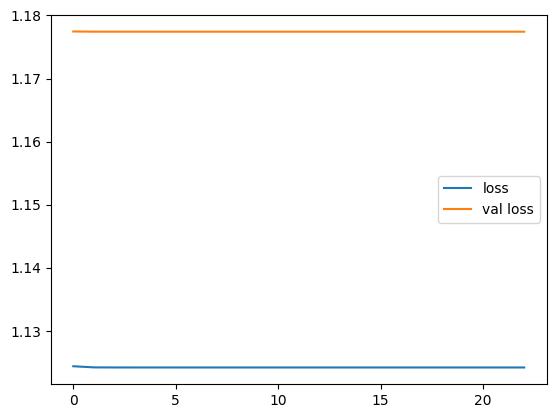

In [47]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend()

In [48]:
cnn.evaluate(X_test, y_test)

37/37 [==============================] - 0s 6ms/step - loss: 1.1359 - accuracy: 0.1702


[1.1359187364578247, 0.17023096978664398]

37/37 [==============================] - 0s 3ms/step
[[145  13  14]
 [583  22  21]
 [318  21  32]]


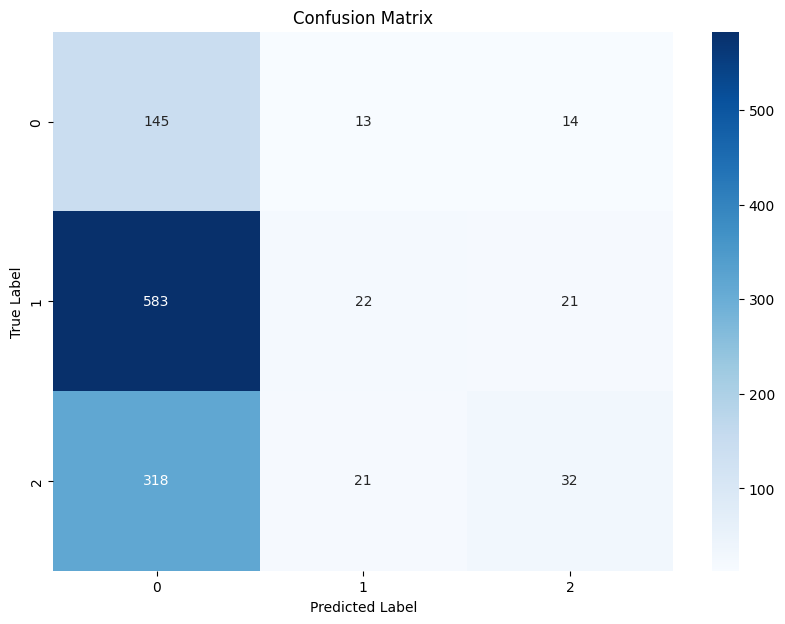

In [49]:
# Obtain predicted labels
y_pred = np.argmax(cnn.predict(X_test), axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

print(cm)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1','2'], yticklabels=['0','1','2'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [50]:
history = cnn_at.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size = 64, epochs = 30,callbacks=[early_stopping])

Epoch 1/30
59/59 [==============================] - 4s 25ms/step - loss: 1.1242 - accuracy: 0.3368 - val_loss: 1.1774 - val_accuracy: 0.3551
Epoch 2/30
59/59 [==============================] - 1s 12ms/step - loss: 1.1242 - accuracy: 0.3202 - val_loss: 1.1774 - val_accuracy: 0.3102
Epoch 3/30
59/59 [==============================] - 0s 8ms/step - loss: 1.1242 - accuracy: 0.3208 - val_loss: 1.1774 - val_accuracy: 0.2856
Epoch 4/30
59/59 [==============================] - 1s 11ms/step - loss: 1.1242 - accuracy: 0.3272 - val_loss: 1.1774 - val_accuracy: 0.2973
Epoch 5/30
59/59 [==============================] - 1s 8ms/step - loss: 1.1242 - accuracy: 0.3301 - val_loss: 1.1774 - val_accuracy: 0.3219
Epoch 6/30
59/59 [==============================] - 1s 11ms/step - loss: 1.1242 - accuracy: 0.3387 - val_loss: 1.1774 - val_accuracy: 0.3091
Epoch 7/30
59/59 [==============================] - 0s 8ms/step - loss: 1.1242 - accuracy: 0.3398 - val_loss: 1.1774 - val_accuracy: 0.2941
Epoch 8/30
59/59

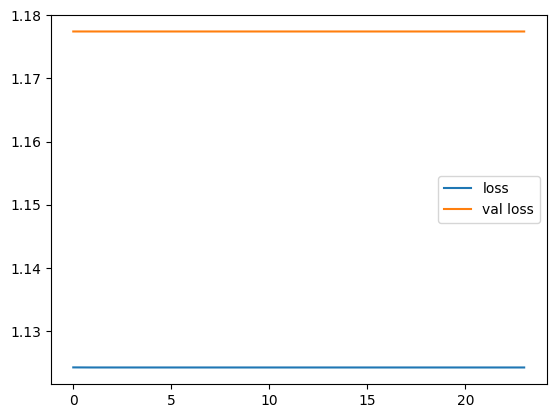

In [51]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend()

In [52]:
cnn_at.evaluate(X_test, y_test)

37/37 [==============================] - 0s 6ms/step - loss: 1.1359 - accuracy: 0.3319


[1.1359186172485352, 0.33190760016441345]

37/37 [==============================] - 0s 5ms/step
[[ 53  75  44]
 [203 234 189]
 [124 146 101]]


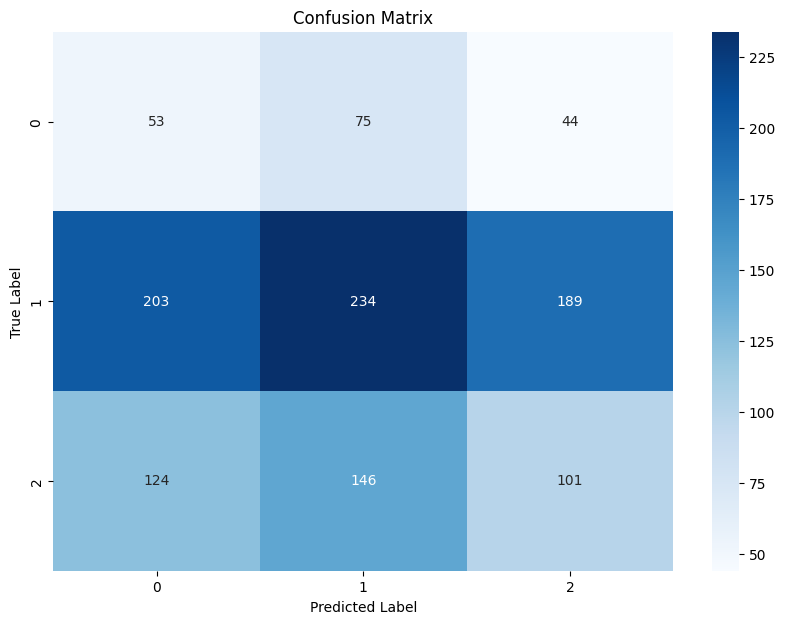

In [53]:
# Obtain predicted labels
y_pred = np.argmax(cnn_at.predict(X_test), axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

print(cm)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1','2'], yticklabels=['0','1','2'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [54]:
history = srnn_at.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size = 64, epochs = 30,callbacks=[early_stopping])

Epoch 1/30
59/59 [==============================] - 18s 249ms/step - loss: 0.9398 - accuracy: 0.5564 - val_loss: 0.9311 - val_accuracy: 0.5786
Epoch 2/30
59/59 [==============================] - 15s 248ms/step - loss: 0.8760 - accuracy: 0.6126 - val_loss: 0.8727 - val_accuracy: 0.5914
Epoch 3/30
59/59 [==============================] - 14s 240ms/step - loss: 0.8404 - accuracy: 0.6236 - val_loss: 0.8584 - val_accuracy: 0.6064
Epoch 4/30
59/59 [==============================] - 15s 249ms/step - loss: 0.8305 - accuracy: 0.6319 - val_loss: 0.8496 - val_accuracy: 0.5947
Epoch 5/30
59/59 [==============================] - 15s 251ms/step - loss: 0.8097 - accuracy: 0.6447 - val_loss: 0.8136 - val_accuracy: 0.6182
Epoch 6/30
59/59 [==============================] - 15s 260ms/step - loss: 0.7529 - accuracy: 0.6667 - val_loss: 0.7754 - val_accuracy: 0.6396
Epoch 7/30
59/59 [==============================] - 14s 232ms/step - loss: 0.7281 - accuracy: 0.6811 - val_loss: 0.7816 - val_accuracy: 0.6342

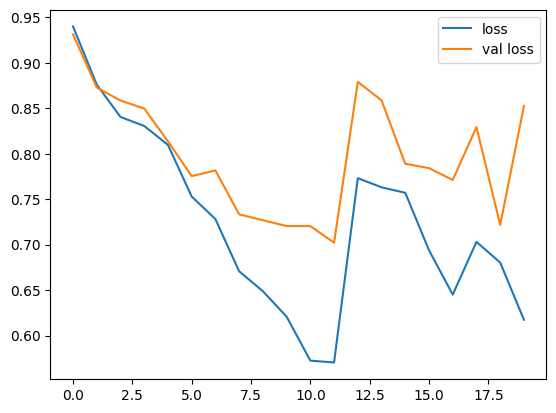

In [55]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend()

In [56]:
srnn_at.evaluate(X_test, y_test)

37/37 [==============================] - 1s 23ms/step - loss: 0.6825 - accuracy: 0.6869


[0.682481586933136, 0.6869118809700012]

37/37 [==============================] - 1s 22ms/step
[[ 40  68  64]
 [ 45 508  73]
 [ 11 105 255]]


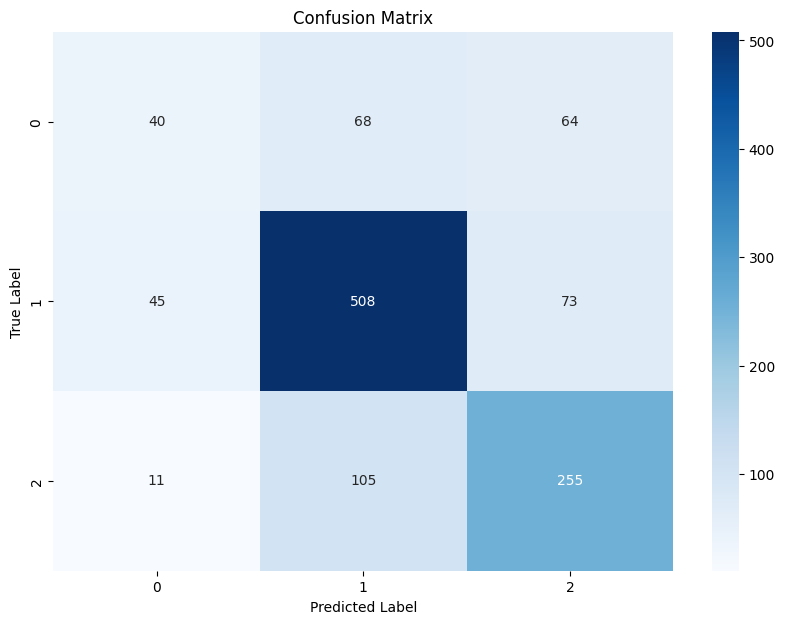

In [57]:
# Obtain predicted labels
y_pred = np.argmax(srnn_at.predict(X_test), axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

print(cm)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1','2'], yticklabels=['0','1','2'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [58]:
history = slstm.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size = 64, epochs = 30,callbacks=[early_stopping])

Epoch 1/30
59/59 [==============================] - 6s 46ms/step - loss: 1.0236 - accuracy: 0.5342 - val_loss: 0.9956 - val_accuracy: 0.5123
Epoch 2/30
59/59 [==============================] - 2s 27ms/step - loss: 0.9502 - accuracy: 0.5433 - val_loss: 0.9260 - val_accuracy: 0.5401
Epoch 3/30
59/59 [==============================] - 2s 28ms/step - loss: 0.8795 - accuracy: 0.5848 - val_loss: 0.8925 - val_accuracy: 0.5914
Epoch 4/30
59/59 [==============================] - 1s 25ms/step - loss: 0.8678 - accuracy: 0.6199 - val_loss: 0.8749 - val_accuracy: 0.5936
Epoch 5/30
59/59 [==============================] - 1s 24ms/step - loss: 0.8475 - accuracy: 0.6281 - val_loss: 0.8723 - val_accuracy: 0.5872
Epoch 6/30
59/59 [==============================] - 1s 23ms/step - loss: 0.8311 - accuracy: 0.6324 - val_loss: 0.8571 - val_accuracy: 0.6000
Epoch 7/30
59/59 [==============================] - 1s 20ms/step - loss: 0.8178 - accuracy: 0.6375 - val_loss: 0.8804 - val_accuracy: 0.6128
Epoch 8/30
59

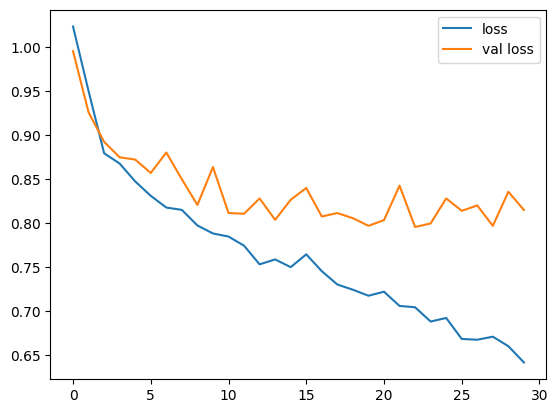

In [59]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend()

In [60]:
slstm.evaluate(X_test, y_test)

37/37 [==============================] - 0s 10ms/step - loss: 0.8131 - accuracy: 0.6612


[0.8130508065223694, 0.6612489223480225]

In [83]:
history = slstm_at.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size = 64, epochs = 30,callbacks=[early_stopping])

Epoch 1/30
59/59 [==============================] - 3s 47ms/step - loss: 0.5404 - accuracy: 0.7533 - val_loss: 0.6955 - val_accuracy: 0.7048
Epoch 2/30
59/59 [==============================] - 2s 27ms/step - loss: 0.5271 - accuracy: 0.7627 - val_loss: 0.7421 - val_accuracy: 0.7005
Epoch 3/30
59/59 [==============================] - 2s 33ms/step - loss: 0.5160 - accuracy: 0.7702 - val_loss: 0.7472 - val_accuracy: 0.6834
Epoch 4/30
59/59 [==============================] - 3s 42ms/step - loss: 0.5205 - accuracy: 0.7571 - val_loss: 0.7581 - val_accuracy: 0.6898
Epoch 5/30
59/59 [==============================] - 2s 31ms/step - loss: 0.5105 - accuracy: 0.7673 - val_loss: 0.7806 - val_accuracy: 0.6781
Epoch 6/30
59/59 [==============================] - 2s 31ms/step - loss: 0.5013 - accuracy: 0.7718 - val_loss: 0.7255 - val_accuracy: 0.6963
Epoch 7/30
59/59 [==============================] - 3s 49ms/step - loss: 0.5068 - accuracy: 0.7667 - val_loss: 0.7222 - val_accuracy: 0.6952
Epoch 8/30
59

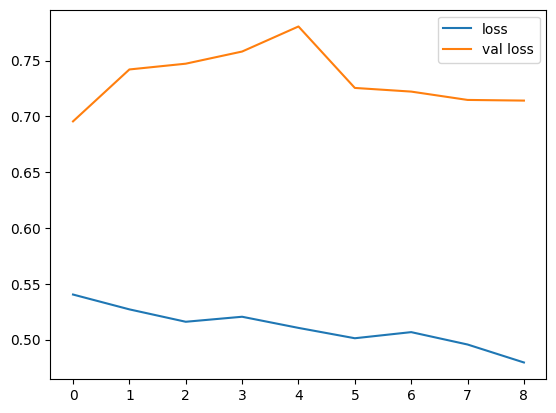

In [84]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend()

In [85]:
slstm_at.evaluate(X_test, y_test)

37/37 [==============================] - 0s 10ms/step - loss: 0.6853 - accuracy: 0.6989


[0.685264527797699, 0.6988879442214966]

37/37 [==============================] - 0s 8ms/step
[[  0  74  98]
 [  0 494 132]
 [  0  92 279]]


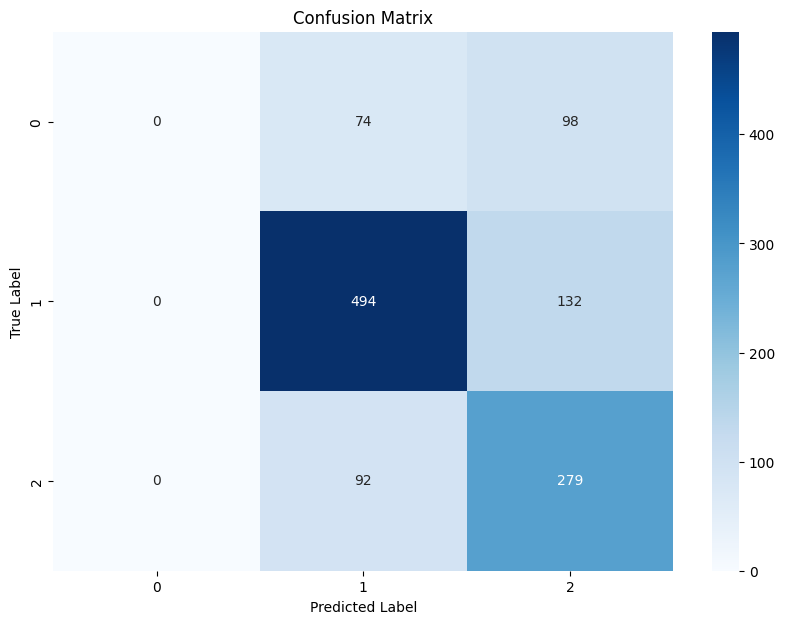

In [86]:
#Confusion matrix
y_pred = np.argmax(slstm.predict(X_test), axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

print(cm)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1','2'], yticklabels=['0','1','2'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

37/37 [==============================] - 0s 9ms/step


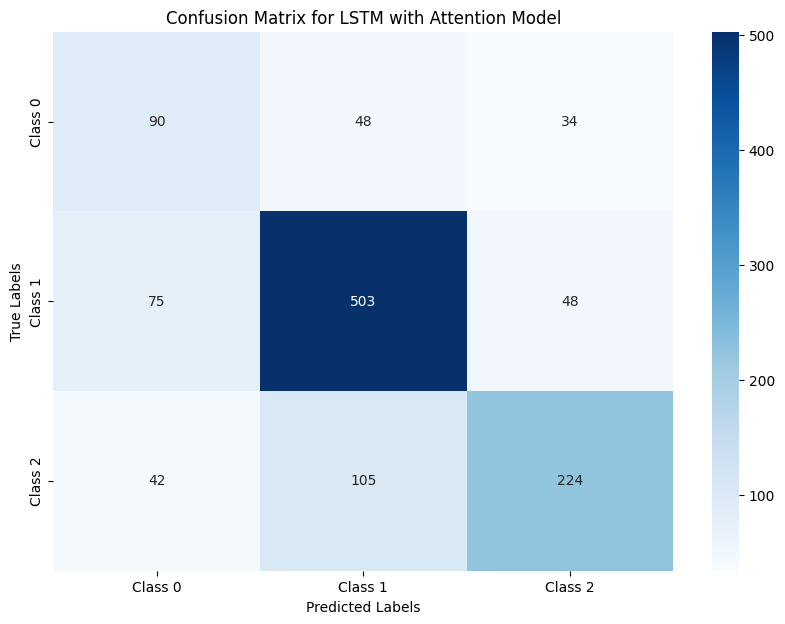

In [87]:
#add the confusion matrix and plot here for your lstm_at model
y_pred = slstm_at.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Assuming y_test is already a one-dimensional array of labels, directly use it.
# If y_test is one-hot encoded, convert it:
# y_true = np.argmax(y_test, axis=1)
y_true = y_test  # Use directly if it's not one-hot encoded

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for LSTM with Attention Model')
plt.show()

# Acknowledgement

**Acknowledge**

https://www.kaggle.com/code/azzamradman/04-dl-nlp-part-1/notebook

**dataset citation**

Malo, Pekka, et al. "Good debt or bad debt: Detecting semantic orientations in economic texts." Journal of the Association for Information Science and Technology 65.4 (2014): 782-796.
